In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.densenet import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, img_size = 299,
                                               mean_proc='VGG16_ImageNet', test_size=0.1)

FileNotFoundError: [Errno 2] No such file or directory: '/data/examples/flower_classification/mapping.csv'

# Xception Fine Tuning

In [3]:
model_name = 'Xception-Fine-Tune'

img_rows, img_cols, img_channel = 299, 299, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 10
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 138s - loss: 0.9933 - acc: 0.6140 - val_loss: 0.5138 - val_acc: 0.8381

Epoch 00001: val_loss improved from inf to 0.51378, saving model to ./Xception-Fine-Tune.h5
Epoch 2/100
 - 97s - loss: 0.5641 - acc: 0.8009 - val_loss: 0.4383 - val_acc: 0.8695

Epoch 00002: val_loss improved from 0.51378 to 0.43832, saving model to ./Xception-Fine-Tune.h5
Epoch 3/100
 - 97s - loss: 0.4332 - acc: 0.8424 - val_loss: 0.3429 - val_acc: 0.9008

Epoch 00003: val_loss improved from 0.43832 to 0.34288, saving model to ./Xception-Fine-Tune.h5
Epoch 4/100
 - 98s - loss: 0.3767 - acc: 0.8593 - val_loss: 0.3356 - val_acc: 0.8982

Epoch 00004: val_loss improved from 0.34288 to 0.33559, saving model to ./Xception-Fine-Tune.h5
Epoch 5/100
 - 98s - loss: 0.3257 - acc: 0.8869 - val_loss: 0.3586 - val_acc: 0.9060

Epoch 00005: val_loss did not improve from 0.33559
Epoch 6/100
 - 99s - loss: 0.2727 - acc: 0.9093 - val_loss: 0.3249 - val_acc: 0.9112

Epoch 00006: val_loss improved from 0.33559 to 0.324

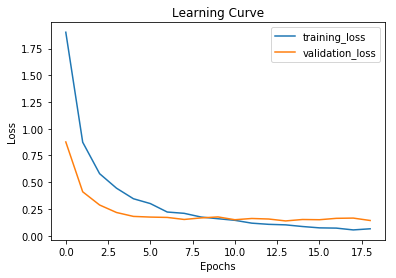

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

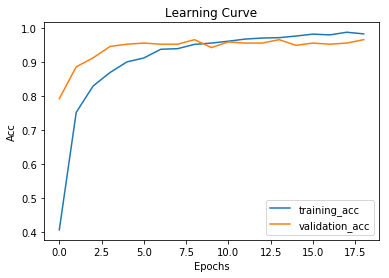

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [3]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', img_size=299)

model_name = 'Xception-Fine-Tune'
model_path = './{}.h5'.format(model_name)
model = load_model(model_path)
y_test_pred_prob = model.predict(X_test)

#y_test_pred = y_test_pred_prob.argmax(axis=-1)
#y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred_prob}).sort_values(by='id')

#y_test_pred_df.to_csv('./{}.csv'.format(model_name), index=False)

'''
scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

'''


ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (0, 1)

In [15]:
y_test_pred_id = pd.DataFrame({'id': np.array(X_id)})
y_test_pred_arr = pd.DataFrame(y_test_pred_prob)
y_test_pred_id.to_csv("./{}_prob.csv".format(model_name), index=False)
y_test_pred_arr.to_csv("./{}_id.csv".format(model_name), index=False)
